<a href="https://colab.research.google.com/github/miller00315/ia_studies/blob/main/milestone_project_skim_nlp_lit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Milestone project: SkimLit 📄 🔥

The pupose of this notebook is to build an NLP mopdel to make reading medial abstarct easier.

The paper we're replicating (the source of the dataset that we'll be using) is available here https://arxiv.org/abs/1710.06071

An reading through the paper above, we see that the model architecture that they use to achiev their best results is available here: https://arxiv.org/abs/1612.05251

# Confirm access to GPU

In [6]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-13969af8-d0dc-e9e8-cf9c-18b51e157557)


## Get data

Since we'll be replicating the paper above (PubMed 200k RCT) , let's download the dataset they used.

We can do so from the authors GitHub: https://github.com/Franck-Dernoncourt/pubmed-rct

In [7]:

!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 39 (delta 8), reused 5 (delta 5), pack-reused 25
Receiving objects: 100% (39/39), 177.08 MiB | 14.74 MiB/s, done.
Resolving deltas: 100% (15/15), done.
Updating files: 100% (13/13), done.
PubMed_200k_RCT				       PubMed_20k_RCT_numbers_replaced_with_at_sign
PubMed_200k_RCT_numbers_replaced_with_at_sign  README.md
PubMed_20k_RCT


In [8]:
# Check what files are in the PubMed_20K dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign

dev.txt  test.txt  train.txt


In [9]:
# Start our experiments using the 20k dataset with numbers replaced by "@"  sign
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign"

In [10]:

# Check all of the filenames in the target directory
import os
filenames = [data_dir + '/' + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

## Preprocess data

Now we've got some text data, it's time to become one with it.

And one of the best ways to become one with the data is to...

> Visualize, visualize, visualize.

So with that in mind, let's write a function to read in all of the lines of a target text file.

In [11]:

# Create function to read the lines of a document
def get_lines(filename):
  """
  Reads filename (a text file) and returns the lines of text as a list.

  Args:
      filename: a string containing the target filepath to read.

  Returns:
      A list of strings with one string per line from the target filename.
      For example:
      ["this is the first line of filename",
       "this is the second line of filename",
       "..."]
  """
  with open(filename, "r") as f:
    return f.readlines()

In [12]:
# Let's read in the trining lines

training_lines = get_lines(filenames[1])
training_lines[:20] # the whole first example of the training data

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [13]:

train_lines = get_lines(data_dir + '/' + "train.txt")
train_lines[:20] # the whole first example of an abstract + a little more of the next one

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

Let's think about how we want our data to look.

How I think our data would be best represented...

```
[{'line_number': 0,
   'target': 'BACKGROUND',
   'text': 'Emotional eating is associated eith overeating and the development of obesity.\n',
   'total_lines': 11},
...
]

  ```

Let's write a function which turns each of our dtasets into the above format so we can continue to prepare our data for modelling.

In [14]:

def preprocess_text_with_line_numbers(filename):
  """Returns a list of dictionaries of abstract line data.

  Takes in filename, reads its contents and sorts through each line,
  extracting things like the target label, the text of the sentence,
  how many sentences are in the current abstract and what sentence number
  the target line is.

  Args:
      filename: a string of the target text file to read and extract line data
      from.

  Returns:
      A list of dictionaries each containing a line from an abstract,
      the lines label, the lines position in the abstract and the total number
      of lines in the abstract where the line is from. For example:

      [{"target": 'CONCLUSION',
        "text": The study couldn't have gone better, turns out people are kinder than you think",
        "line_number": 8,
        "total_lines": 8}]
  """
  input_lines = get_lines(filename) # get all lines from filename
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts

  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"): # check to see if line is an ID line
      abstract_id = line
      abstract_lines = "" # reset abstract string
    elif line.isspace(): # check to see if line is a new line
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in abstract and count them at the same time
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {} # create empty dict to store data from line
        target_text_split = abstract_line.split("\t") # split target label from text
        line_data["target"] = target_text_split[0] # get target label
        line_data["text"] = target_text_split[1].lower() # get target text and lower it
        line_data["line_number"] = abstract_line_number # what number line does the line appear in the abstract?
        line_data["total_lines"] = len(abstract_line_split) - 1 # how many total lines are in the abstract? (start from 0)
        abstract_samples.append(line_data) # add line data to abstract samples list

    else: # if the above conditions aren't fulfilled, the line contains a labelled sentence
      abstract_lines += line

  return abstract_samples





In [15]:
# Get data from file and preprocess it
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "/" + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "/" + "dev.txt") # dev is another name for validation set
test_samples = preprocess_text_with_line_numbers(data_dir + "/" + "test.txt")
len(train_samples), len(val_samples), len(test_samples)

CPU times: user 545 ms, sys: 108 ms, total: 653 ms
Wall time: 675 ms


(180040, 30212, 30135)

In [16]:

# Check the first abstract of our training data
train_samples[:14]

[{'target': 'OBJECTIVE',
  'text': 'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'secondary outcome measures included the western ontari

Now that our data is the format of a list of dictionaries, how about we turn it into a DataFrame to further visualize it?

In [17]:

import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [18]:
# Distribution of labels in training data
train_df.target.value_counts()

target
METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: count, dtype: int64

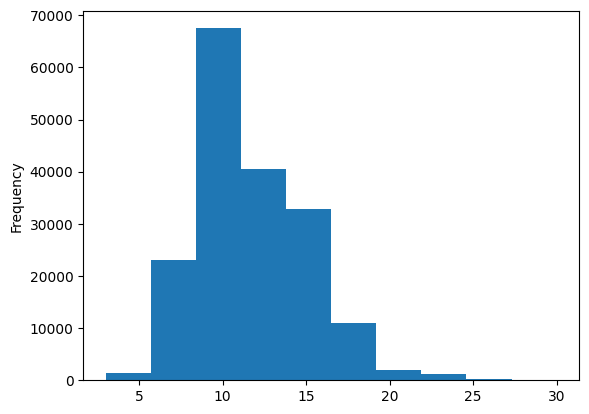

In [19]:
# Let's check the length of different lines

train_df.total_lines.plot.hist();

### Get lists of sentences

In [20]:
# Convert abstract text lines into lists
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [21]:
# View first 10 lines of training sentences
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Make numeric labels (ML models required numeric labels)

In [22]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1))
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1))
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1))

# Check what training labels look like
train_labels_one_hot

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [23]:
import sklearn
print(sklearn.__version__)

1.2.2


### Label encode labels

In [24]:
# Extract labels ("target" columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

# Check what training labels look like
train_labels_encoded

array([3, 2, 2, ..., 4, 1, 1])

In [25]:
# Get class names and number of classes from LabelEncoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

### Starting a series of modelling experiments...

As usual, we're going to be trying out a bunch of diffferent models and seeing which one works best.

Ans as always we're going to start by building a baseline ([TF-IDF](http://tfidf.com) Multinomial Naive Bayes classifier).

[Chris Albon](https://chrisalbon.com/Home)

## Model 0: Getting a baseline

In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create a pipeline
model_0 = Pipeline([
  ("tf-idf", TfidfVectorizer()),
  ("clf", MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(X=train_sentences,
            y=train_labels_encoded);
model_0.fit(X=train_sentences,
            y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate baseline on validation dataset
model_0.score(X=val_sentences,
              y=val_labels_encoded)

0.7218323844829869

In [28]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds

array([4, 1, 3, ..., 4, 4, 1])

In [29]:
val_labels_encoded

array([0, 0, 3, ..., 4, 1, 1])

### Download helper functions

In the previous module, we wrote functions across different metrics (accuracy, precision, recall, f1-score).

We can download them from GitHub.

In [30]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2024-06-15 20:25:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-06-15 20:25:59 (114 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [31]:
# Import calculate_results helper function
from helper_functions import calculate_results

In [32]:
# Calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [33]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

## Preparing our data (the text) for deep sequence models

Before we start building deper models, we've got to create vectorization and embedding layers.


In [34]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [35]:
train_sentences[:10]

['to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .',
 'a total of @ patients with primary knee oa were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'secondary outcome measures included the western ontario and mcmaster universities osteoarthritis index scores , patient global assessment ( pga ) of the severity of knee oa , and @-min walk distance ( @mwd ) .',
 'serum levels of interleukin @ ( il-@ ) , il-@ , tumor necrosis factor ( tnf ) - , and high-sensitivity c-reactive protein ( hscrp ) were measured .',
 'there was a clinic

In [36]:
# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # return average sentence length (in tokens)

26.338269273494777

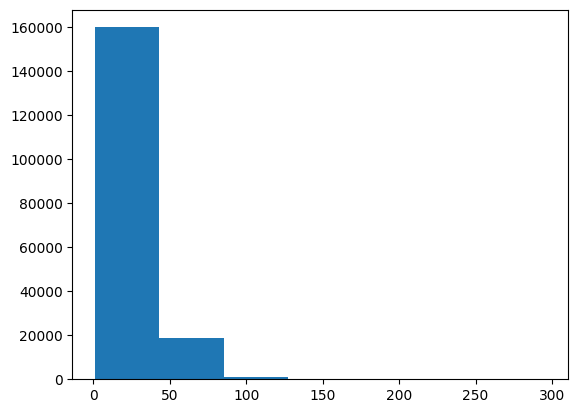

In [37]:
# What's the distribution look like?

import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=7);

In [38]:
# How long of a sentence covers 95% of the lengths?
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len


55

In [39]:
# Maximun sequence length in the training set

max(sent_lens)

296

### Create text vectorizer layer

We wnat to make a layer which maps our text from words to numbers.

In [40]:
# How many words are in our vocab? (taken from table 2 in: https://arxiv.or/pdf/1710.06071.pdf)

max_tokens = 68000

In [41]:
# create text vectorizer

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=55)

In [42]:
# Adapt text vectorizer to training sentences

text_vectorizer.adapt(train_sentences)

In [43]:
# Test out text vectorizer on random sentences
import random

target_sentence = random.choice(train_sentences)

print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence.split())}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
the statistically significant decrease was observed in the mean levels of serum tnf - in the medulla ( @ ) and whole fruit ( @ ) groups after @ weeks of supplementation .

Length of text: 33

Vectorized text:
[[    2   232    37   318    10   148     5     2    57    93     4   225
   1558     5     2 16938     3  1300  2478    24    21    53     4   464
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [44]:
# How many words in our training vocabulary

rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Most common words in the vocab: {rct_20k_text_vocab[:5]}")
print(f"Least common words in the vocab: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Most common words in the vocab: ['', '[UNK]', 'the', 'and', 'of']
Least common words in the vocab: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [45]:
# Get the config ou our text vectorizer

text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

#### Create a custom text embedding

In [46]:
# Create token embedding layer
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab), # length of vocabulary
                               output_dim=128, # Note: different embedding sizes result in drastically different numbers of parameters to train
                               # Use masking to handle variable sequence lengths (save space)
                               mask_zero=True,
                               name="token_embedding")

# Show example embedding
print(f"Sentence before vectorization:\n{target_sentence}\n")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"Sentence after vectorization (before embedding):\n{vectorized_sentence}\n")
embedded_sentence = token_embed(vectorized_sentence)
print(f"Sentence after embedding:\n{embedded_sentence}\n")

Sentence before vectorization:
the statistically significant decrease was observed in the mean levels of serum tnf - in the medulla ( @ ) and whole fruit ( @ ) groups after @ weeks of supplementation .

Sentence after vectorization (before embedding):
[[    2   232    37   318    10   148     5     2    57    93     4   225
   1558     5     2 16938     3  1300  2478    24    21    53     4   464
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]

Sentence after embedding:
[[[ 0.02332579 -0.02318522  0.00769986 ... -0.03999804  0.00916245
    0.0128918 ]
  [ 0.0460046   0.02961497  0.01577331 ... -0.03846509  0.01316394
   -0.04334353]
  [ 0.02772305 -0.0146067   0.00753882 ...  0.04130233 -0.03591551
    0.035521  ]
  ...
  [ 0.01215959 -0.00942168  0.03086177 ...  0.04143275  0.03044787
   -0.00358266]
  [ 0.01215959 -0.00942168  0.03086177 ..

## Creating datasets (making sure our data loads as fast as possible)

We're going to setup our data to run as fast as possible with the tensor flow tf.data API, many of the steps here are dicussed at length in these two resources:

* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [47]:
# Turn our data into TensorFlow Datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>

In [48]:
train_labels_encoded.shape, train_labels_one_hot[0]

((180040,), array([0., 0., 0., 1., 0.]))

In [49]:


# Take the TensorSliceDataset's and turn them into prefetched batches
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset


<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [50]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D with token embedding

In [51]:

# Create 1D convolutional model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs) # vectorize text inputs
token_embeddings = token_embed(text_vectors) # create embedding
x = layers.Conv1D(64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalAveragePooling1D()(x) # condense the output of our feature vector
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs)

# Compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [52]:

# Get summary of Conv1D model
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 token_embedding (Embedding  (None, 55, 128)           8299648   
 )                                                               
                                                                 
 conv1d (Conv1D)             (None, 55, 64)            41024     
                                                                 
 global_average_pooling1d (  (None, 64)                0         
 GlobalAveragePooling1D)                                         
                                                             

In [53]:
len(train_dataset)

5627

In [54]:


# Fit the model
model_1_history = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)), # only fit on 10% of batches for faster training time
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset))) # only validate on 10% of batches

Epoch 1/3
562/562 [==============================] - 20s 31ms/step - loss: 0.9194 - accuracy: 0.6349 - val_loss: 0.6802 - val_accuracy: 0.7410
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.6556 - accuracy: 0.7578 - val_loss: 0.6321 - val_accuracy: 0.7719
Epoch 3/3
562/562 [==============================] - 4s 7ms/step - loss: 0.6136 - accuracy: 0.7759 - val_loss: 0.5939 - val_accuracy: 0.7889


In [55]:
# Evaluate on whole validation set

model_1.evaluate(valid_dataset)

945/945 [==============================] - 3s 3ms/step - loss: 0.5962 - accuracy: 0.7883


[0.5961774587631226, 0.7882960438728333]

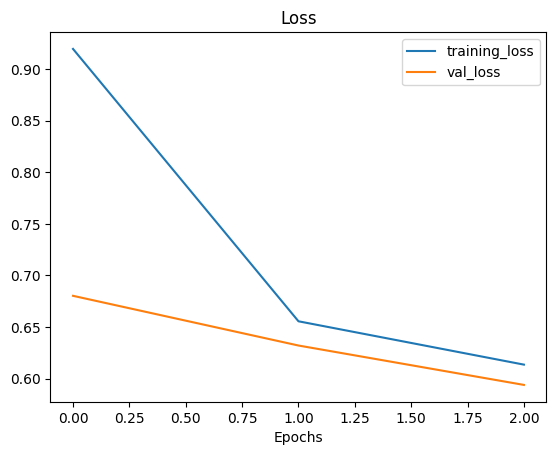

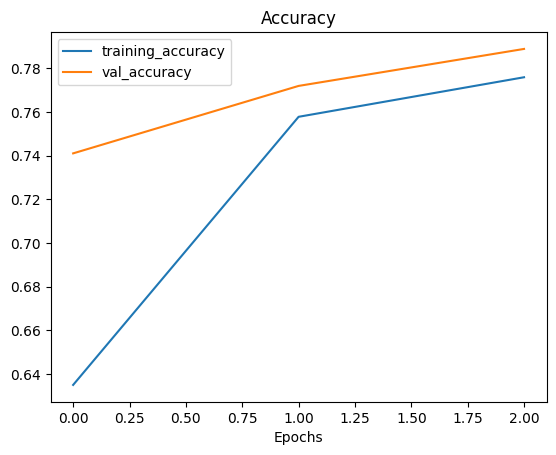

In [56]:
from helper_functions import plot_loss_curves

plot_loss_curves(model_1_history)

In [57]:
# Make predicitons (our model predicition probabilities for each class)
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs, model_1_pred_probs.shape

945/945 [==============================] - 3s 3ms/step


(array([[4.5646307e-01, 1.3648820e-01, 8.6151630e-02, 2.9398757e-01,
         2.6909526e-02],
        [4.1411549e-01, 2.8823271e-01, 1.3535076e-02, 2.7574965e-01,
         8.3670598e-03],
        [1.4414342e-01, 7.7379853e-03, 1.8276561e-03, 8.4626019e-01,
         3.0791482e-05],
        ...,
        [8.3136792e-06, 6.6476216e-04, 7.6131301e-04, 3.9519905e-06,
         9.9856168e-01],
        [5.7942908e-02, 4.4933423e-01, 1.2474381e-01, 7.1729705e-02,
         2.9624936e-01],
        [1.4511052e-01, 7.1278358e-01, 3.5232931e-02, 4.9036898e-02,
         5.7836078e-02]], dtype=float32),
 (30212, 5))

In [58]:
# Convert pred probs to clases
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 1, 1])>

In [59]:
# sho pres as text class
for i in model_1_preds[:20]:
  print(f"Pred: {class_names[i]}")

Pred: BACKGROUND
Pred: BACKGROUND
Pred: OBJECTIVE
Pred: METHODS
Pred: RESULTS
Pred: METHODS
Pred: RESULTS
Pred: METHODS
Pred: RESULTS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: OBJECTIVE
Pred: METHODS
Pred: METHODS
Pred: CONCLUSIONS
Pred: CONCLUSIONS
Pred: RESULTS
Pred: CONCLUSIONS


In [60]:
# Calculate model_1 results

model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 78.82960413080895,
 'precision': 0.7854447835919653,
 'recall': 0.7882960413080895,
 'f1': 0.7860897218121181}

## Model 2: Feature extractiion with pretrained token embeddings

Now lets use pretrained word embeddings from TensorFlow Hub, more specificically the universal sentece encoder: https://tfhub.dev/google/universal-sentence-encoder/4

The paper originally used GloVe embeddings. however, we're going to stck with the later created USE pretrained embeding

In [61]:
# Download pretarined TensorFlow Hub USE

import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [62]:
train_sentences = train_df["text"].tolist()
val_sentences = val_df["text"].tolist()
test_sentences = test_df["text"].tolist()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [63]:
# test out the pretrained embedding on a random sentence
random_training_sentence = random.choice(train_sentences)
print(f"Random training sentence:\n{random_training_sentence}\n")
use_embedded_sentence = tf_hub_embedding_layer([random_training_sentence])
print(f"Sentence after embedding:\n{use_embedded_sentence[0][:30]}\n")
print(f"Length of sentence embedding:\n{len(use_embedded_sentence[0])}")

Random training sentence:
the safety and efficacy of tenofovir disoproxil fumarate ( tdf ) in hiv-@-infected children have not been evaluated in a randomized controlled trial .

Sentence after embedding:
[-0.00059301  0.00386174 -0.0483496  -0.05035562 -0.07900773  0.03539297
  0.07754338 -0.00485287 -0.03692306  0.03701431  0.08670022  0.02109903
  0.06974356  0.08253902  0.0295497   0.0029102  -0.09122024  0.06159478
 -0.01045263 -0.06011904  0.00737138  0.01828137 -0.0890948  -0.00044368
 -0.01650429 -0.01775285  0.04505529  0.07075795 -0.04764608  0.06754167]

Length of sentence embedding:
512


## Building and fitting an NLP feature extraction model using pretrained embeddings from TensorFlow Hub

In [64]:
# Defime feature extraction model using TF Hub layer

inputs = layers.Input(shape=[], dtype=tf.string)
pretrained_embedding = tf_hub_embedding_layer(inputs) # tokenize text and create embedding of each sequnece (512 long vector)
x = layers.Dense(128, activation="relu")(pretrained_embedding)
# Note:you could ad more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the outpu layer
model_2 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
  )

In [65]:
model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_1 (Dense)             (None, 128)               65664     
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [69]:
model_2_history = model_2.fit(train_dataset,
            steps_per_epoch=int(0.1 * len(train_dataset)),
            epochs=3,
            validation_data=valid_dataset,
            validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 9s 15ms/step - loss: 0.7253 - accuracy: 0.7247 - val_loss: 0.7099 - val_accuracy: 0.7221
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.6965 - accuracy: 0.7319 - val_loss: 0.6937 - val_accuracy: 0.7304
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.6866 - accuracy: 0.7383 - val_loss: 0.6907 - val_accuracy: 0.7291


In [70]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 11s 12ms/step - loss: 0.6990 - accuracy: 0.7309


[0.6989563703536987, 0.730934739112854]

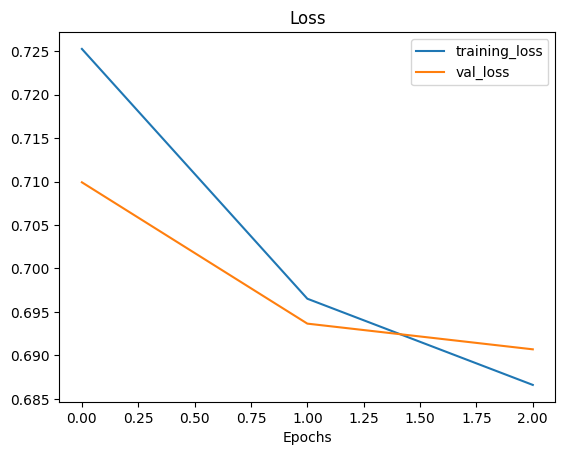

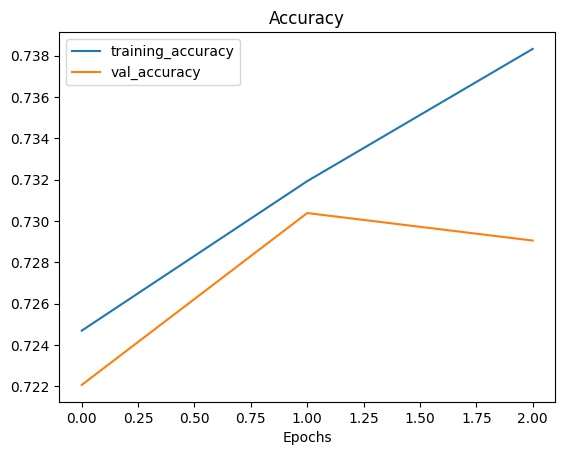

In [71]:
plot_loss_curves(model_2_history)

In [72]:
#Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs

945/945 [==============================] - 11s 11ms/step


array([[4.0253448e-01, 3.8117826e-01, 1.0280308e-03, 2.0955428e-01,
        5.7049105e-03],
       [4.1191646e-01, 4.4073328e-01, 1.7696456e-03, 1.4422029e-01,
        1.3602489e-03],
       [2.4892455e-01, 6.9100909e-02, 1.2789253e-02, 6.3718235e-01,
        3.2002877e-02],
       ...,
       [1.3838060e-03, 3.5033654e-03, 4.3260891e-02, 5.7315739e-04,
        9.5127875e-01],
       [4.3910500e-03, 5.6347385e-02, 1.7572142e-01, 1.3391321e-03,
        7.6220107e-01],
       [1.4571047e-01, 5.2913165e-01, 2.9942173e-01, 3.0513357e-03,
        2.2684827e-02]], dtype=float32)

In [73]:
# Convert the prediciton probabilities found with feature extraction model to labels

model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 1])>

In [74]:
# Calculate results from TF Hub prerained embeding rresults on val set
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 73.09347279226797,
 'precision': 0.7306739129713061,
 'recall': 0.7309347279226798,
 'f1': 0.7285118590414992}

In [75]:
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [76]:
model_1_results

{'accuracy': 78.82960413080895,
 'precision': 0.7854447835919653,
 'recall': 0.7882960413080895,
 'f1': 0.7860897218121181}